In [1]:
import sys
sys.path.append('..')
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
import random
import os
import cv2
from matplotlib import pyplot as plt
from od import detr_dataset as ds
from common.config import val_annotation_file, val_img_od_dict_file, val_img_dir, train_annotation_file, train_img_od_dict_file, train_img_dir, img_size
from od.config import cid_to_name
from torchvision import transforms
from od.box import cxcywh_to_xyxy
from od import detr_model, examine, anno, anchor, detr_model_base
import random
from tqdm import tqdm
%matplotlib inline

In [2]:
dicts_val = anno.build_img_dict(val_annotation_file, val_img_od_dict_file, task='od')
dicts_train = anno.build_img_dict(train_annotation_file, train_img_od_dict_file, task='od')

In [3]:
# model with predefined anchors
device = torch.device("mps")
anchors = torch.tensor(anchor.generate_anchors(), device=device)
n_anchor = anchors.shape[0]
model = detr_model.DETR(d_cont=384, d_head=64, d_enc_coord_emb=64, d_dec_coord_emb=32,
                        n_enc_layer=20, n_dec_layer=8, exam_diff=True)
model.to(device)
pass

In [4]:
n_head = 8

saved_state = torch.load(f'/Users/zx/Documents/ml/restart/resources/od_detr_anchor_55.pt', map_location=device)

model.load_state_dict(saved_state)

extractor = examine.FeatureExtractor(model, layers=[m[0] for m in model.named_modules()])

torch.Size([1, 1044, 512])
torch.Size([1, 1044, 512])
torch.Size([1, 1044, 512])
torch.Size([1, 1044, 512])
torch.Size([1, 1044, 512])
torch.Size([1, 1044, 512])
6


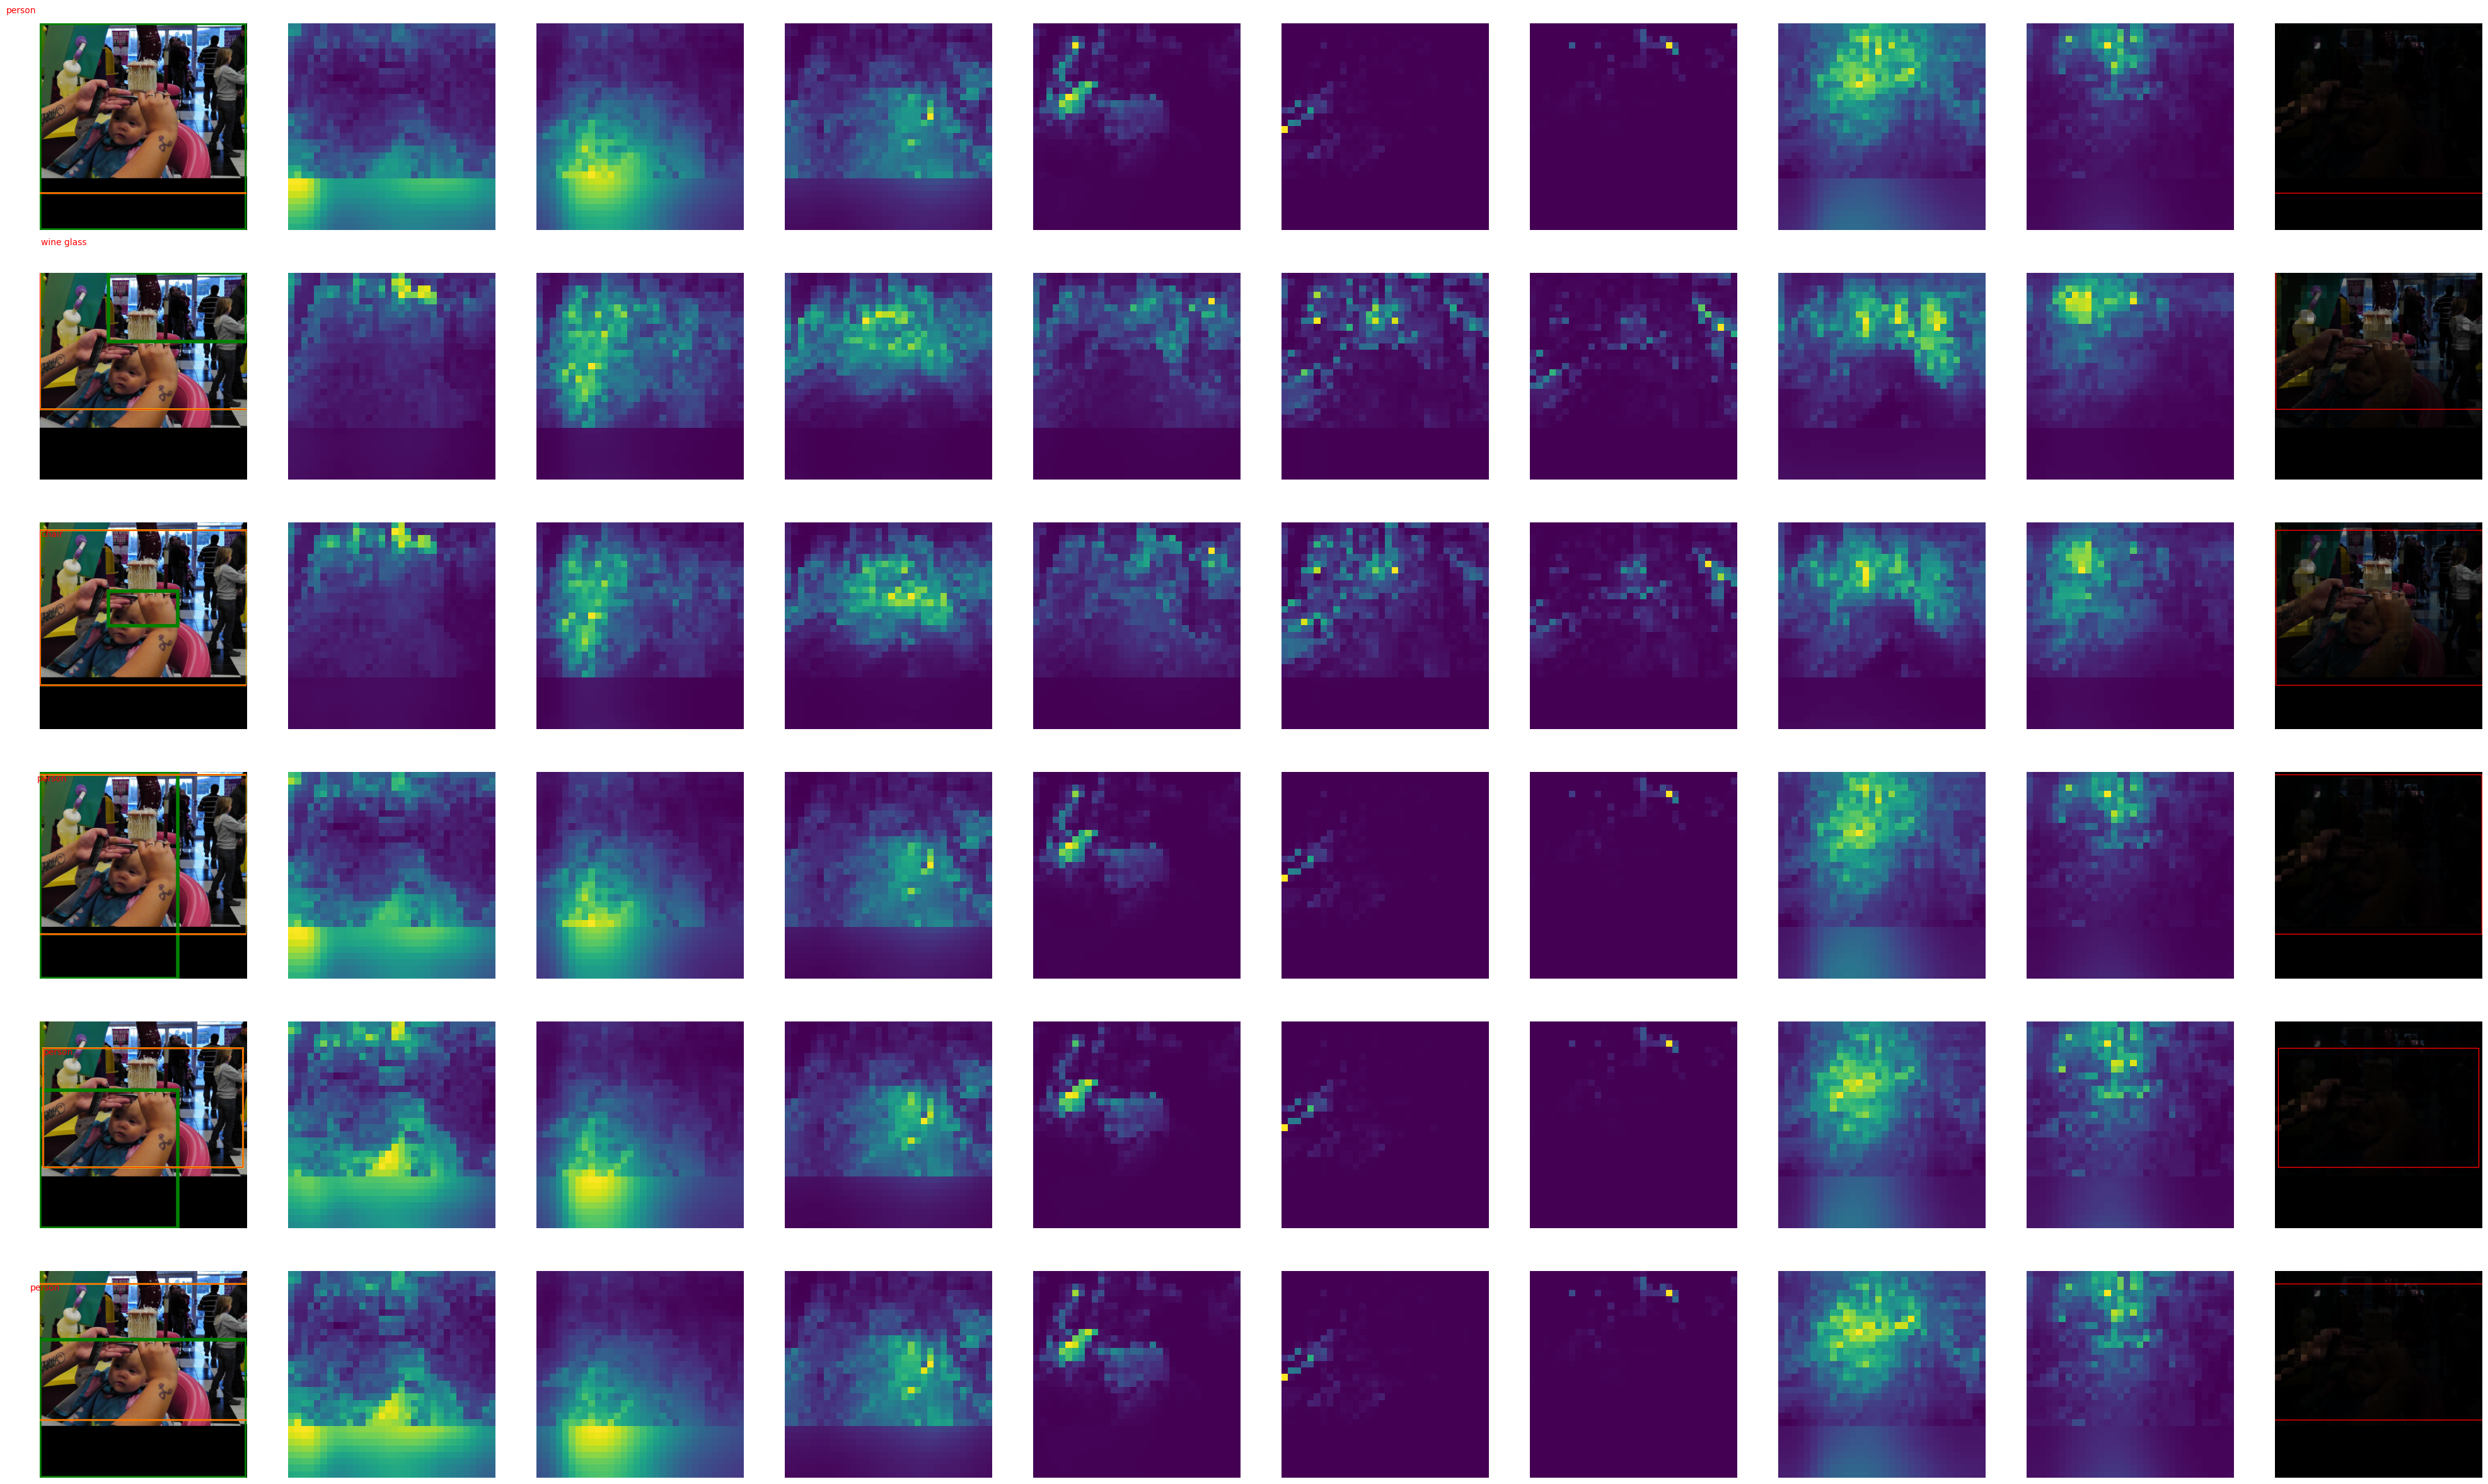

In [9]:
# for random val data

data = ds.OdDataset(dicts_val, n_query=anchors.shape[0], train=False, sample_num=10, random_shift=False)
dl = DataLoader(data, batch_size=1, shuffle=True)


for img, boxes_gt_xyxy, cids, _, img_id in dl:
    img = img.to(device)
    img, anchors_, anchors_new, boxes, names, attns1, attns2, n_head, boxes_pred_xyxy, cls_pred = examine.examine_attn(
        img, extractor, n_head, device, 
        'decoder.ca_layers.0.self_attn.q_proj', 'decoder.ca_layers.0.self_attn.k_proj', 
        'decoder.ca_layers.1.self_attn.q_proj', 'decoder.ca_layers.1.self_attn.k_proj',
        anchors
    )
    print(len(boxes))
    if len(boxes) > 0:
        examine.draw_attn(img, anchors_, anchors_new, boxes, names, attns1, n_head)
#         examine.draw_attn(img, anchors_, anchors_new, boxes, names, attns2, n_head)
        
    break

In [ ]:
img_ids = ['516176']

imgs = []
for img_id in img_ids:
    img, _, _, _, _ = ds.get_gt_by_img_id(img_id, dicts_train, train_img_dir, img_size, random_shift=False, n_query=len(anchors))
    imgs.append(img)
imgs = torch.stack(imgs, dim=0)
imgs= imgs.to(device)

n_head = 9

img, anchors_, boxes, names, attns1, attns2, n_head, boxes_pred_xyxy, cls_pred = examine.examine_attn(
    imgs, extractor, n_head, device, 
    'decoder.ca_layers.0.self_attn.q_proj', 'decoder.ca_layers.0.self_attn.k_proj', 
    'decoder.ca_layers.7.self_attn.q_proj', 'decoder.ca_layers.7.self_attn.k_proj',
    anchors
)
print(len(boxes))
# examine.draw_attn(img, anchors_, boxes, names, attns1, n_head)
examine.draw_attn(img, anchors_, boxes, names, attns2, n_head)

In [ ]:
for name, param in model.named_parameters():
    print(name)

In [97]:
popul = 4000
# for random val data
stat = {i: [] for i in range(n_anchor)}
data = ds.OdDataset(dicts_val, n_query=anchors.shape[0], train=False, sample_num=popul, random_shift=False)
dl = DataLoader(data, batch_size=1, shuffle=True)

for img, boxes_gt_xyxy, cids, _, img_id in tqdm(dl):
    img_ = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    img_ = img_.to(device)
    with torch.no_grad():
        boxes_pred_xyxy, cls_logits_pred, _, _ = extractor.model(img_, anchors)
        boxes_pred_xyxy = boxes_pred_xyxy * max(img_size)
        cls_pred_sm = cls_logits_pred.softmax(-1)
        cls_pred = cls_pred_sm.argmax(-1)
        for i in range(n_anchor):
            if cls_pred[0, i] > 0:
                stat[i].append(cls_pred[0, i].item())
            

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [1:11:49<00:00,  1.08s/it]


In [98]:
stat

{0: [37, 1, 10, 1, 62, 10, 62, 62, 3, 1, 1, 59, 3, 1],
 1: [1, 10, 38, 1, 1, 1, 1, 1, 13, 62, 59],
 2: [85, 10, 1, 44, 1, 10, 1, 1, 62, 3, 13, 1, 62, 75],
 3: [10, 1, 1, 1, 1, 75, 1, 1, 56, 62],
 4: [1, 1, 1, 1, 3],
 5: [3, 1, 1, 1, 34, 1, 4, 1, 1],
 6: [1, 1, 3, 53, 1, 53, 3, 10, 64, 1],
 7: [3, 56, 1, 62, 1, 1, 1],
 8: [1, 1, 3, 3, 64, 10, 3, 44, 8, 59],
 9: [55, 10, 24, 1, 72, 43, 44, 59],
 10: [1, 11, 10, 43, 85, 44, 1, 3, 10, 37, 43, 1, 44, 10, 1, 44, 1],
 11: [39, 5, 62, 1, 34, 1, 43, 1, 47, 44, 3, 40, 28, 40, 34],
 12: [41, 1, 75, 32, 1, 10, 40, 1, 62, 85, 41, 1, 27, 5, 1, 85],
 13: [1, 27, 44, 62, 44, 1, 34, 1, 13, 44, 1, 24, 44, 10],
 14: [44, 72, 1, 1, 10, 10, 5],
 15: [10, 1, 47, 64, 3, 55, 3],
 16: [3, 1, 1, 3, 24, 10, 10, 1, 1, 10, 27, 1, 1, 1, 3, 3, 10],
 17: [10,
  3,
  28,
  10,
  28,
  4,
  20,
  8,
  55,
  40,
  41,
  43,
  28,
  38,
  1,
  44,
  25,
  1,
  3,
  10,
  3,
  47,
  75,
  10,
  5],
 18: [1,
  1,
  85,
  41,
  4,
  1,
  1,
  1,
  43,
  1,
  1,
  47,
  1,
 

In [99]:
{k: set(v) for k, v in stat.items() if len(v) > 0}

{0: {1, 3, 10, 37, 59, 62},
 1: {1, 10, 13, 38, 59, 62},
 2: {1, 3, 10, 13, 44, 62, 75, 85},
 3: {1, 10, 56, 62, 75},
 4: {1, 3},
 5: {1, 3, 4, 34},
 6: {1, 3, 10, 53, 64},
 7: {1, 3, 56, 62},
 8: {1, 3, 8, 10, 44, 59, 64},
 9: {1, 10, 24, 43, 44, 55, 59, 72},
 10: {1, 3, 10, 11, 37, 43, 44, 85},
 11: {1, 3, 5, 28, 34, 39, 40, 43, 44, 47, 62},
 12: {1, 5, 10, 27, 32, 40, 41, 62, 75, 85},
 13: {1, 10, 13, 24, 27, 34, 44, 62},
 14: {1, 5, 10, 44, 72},
 15: {1, 3, 10, 47, 55, 64},
 16: {1, 3, 10, 24, 27},
 17: {1, 3, 4, 5, 8, 10, 20, 25, 28, 38, 40, 41, 43, 44, 47, 55, 75},
 18: {1, 3, 4, 5, 9, 40, 41, 43, 47, 56, 77, 85},
 19: {1, 3, 5, 13, 28, 34, 40, 41, 43, 44, 72, 81, 85},
 20: {1, 3, 9, 22, 24, 27, 28, 42, 44, 52, 57, 59},
 21: {1, 3, 9, 20, 28, 40, 44, 75},
 22: {1, 3, 4, 10, 20, 28, 37, 44, 64, 75, 85},
 23: {1, 3, 8, 10, 16},
 24: {1, 3, 8, 9, 10, 20, 21, 28, 44, 84},
 25: {1, 3, 4, 8, 10, 15, 20, 21, 43, 44, 47, 51, 62, 85},
 26: {1, 8, 16, 20, 22, 35, 37, 40, 41, 43, 44, 47, 51

In [ ]:
data = ds.OdDataset(dicts_val, n_query=model.decoder.n_anchor, train=False, sample_num=10, random_shift=False)
dl = DataLoader(data, batch_size=2, shuffle=True)

for img, boxes_gt_xyxy, cids, _, img_id in dl:
    boxes_pred_xyxy, cls_pred = pred_and_show(img, model, thresh=0.1)
    break

In [ ]:
for m in model.named_modules():
    print(m[0])

In [9]:
torch.max(torch.randn(2,3,4), dim=-1)[0]

tensor([[ 0.6090,  1.6414,  1.1212],
        [ 1.8212,  2.0298, -0.0028]])